## Recommendations for Microsoft's New Movie Studio

In this notebook we are going to explore the relationship between the movie success and movie time of release,movie runtime, movie genre, directors, and actors/actresses. 
Success will be based on ROI and Profit margin.


First object is to clean up the movie budget dataframe, then merge all the relevant data sets so we have one dataframe
that is easy to work with.

In [1]:
#Complete cell to create money metrics df for merging
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

# Load all the data.
bom_movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
imdb_name_basics_df = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
imdb_title_akas_df = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
imdb_title_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_title_crew_df = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_title_principals_df = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_title_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin-1')
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

#renaming it to work on
money_metrics_df = tn_movie_budgets_df

#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df

#cleaning
money_metrics_df = clean_a_money_column(money_metrics_df,'worldwide_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'domestic_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'production_budget')

#unique ID for later merging madness
money_metrics_df['mmdf_uni_id'] = money_metrics_df.index

#adding profit margin and ROI columns
numerator = money_metrics_df['worldwide_gross'] - money_metrics_df['production_budget']
money_metrics_df['Profit Margin'] = (numerator*100)/money_metrics_df['worldwide_gross']
money_metrics_df.loc[money_metrics_df['Profit Margin'] == float('-inf'), 'Profit Margin'] = 0
money_metrics_df['ROI'] = (money_metrics_df['worldwide_gross']/money_metrics_df['production_budget'])

# This line of code messes with my data cleaning - Vu
#setting profit margin desc as order for the table
# money_metrics_df=money_metrics_df.sort_values(['Profit Margin'], ascending=False)

#creating year and month columns
#Vu's magic lambda, plus to numeric on the year 
money_metrics_df['Year'] = pd.to_numeric(money_metrics_df['release_date'].map(lambda x: x[-4:]))
money_metrics_df['Month'] = money_metrics_df['release_date'].map(lambda x: x[:3])

#vu's dupe check
movie_dupes = pd.Series(money_metrics_df['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]

#making a new df to do the rename in
title_dupes_df = money_metrics_df[money_metrics_df['movie'].isin(title_dupes)].copy()

#Making the new title by combining the name of the movie and the year of release
title_dupes_df['New Title'] = title_dupes_df['movie'] + ' ' + title_dupes_df['Year'].astype(str)

#creating a new DF dropping all the columns we don't need 
title_dupes_df_merger = title_dupes_df[['mmdf_uni_id', 'New Title']]
#Don't actually know if we need this but, whatever.
money_metrics_df.reset_index(inplace = True)

#reintegrating new titles in a new df mergedf
mergedf = money_metrics_df.merge(title_dupes_df_merger, on = 'mmdf_uni_id', how= 'left')

#vu's slightly less magical de-duplicator
#new column for boolean
mergedf['is_title_NaN'] = mergedf['New Title'].isnull()
#for loop to rename 'Movie'
for movie_index in list(range(len(mergedf.index))):
    if  ~mergedf['is_title_NaN'][movie_index]:
        mergedf['movie'][movie_index] = mergedf['New Title'][movie_index]

display(mergedf.info())

money_metrics_merge_ready_df = mergedf.copy()

#### NOW OUTPUTS A DF CALLED money_metrics_merge_ready
#### TRY TO NOT MESS WITH THIS BLOCK, MAKE A COPY OF money_metrics_merge_ready
#### AND MESS WITH THAT

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 0 to 5781
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              5782 non-null   int64  
 1   id                 5782 non-null   int64  
 2   release_date       5782 non-null   object 
 3   movie              5782 non-null   object 
 4   production_budget  5782 non-null   int64  
 5   domestic_gross     5782 non-null   int64  
 6   worldwide_gross    5782 non-null   int64  
 7   mmdf_uni_id        5782 non-null   int64  
 8   Profit Margin      5782 non-null   float64
 9   ROI                5782 non-null   float64
 10  Year               5782 non-null   int64  
 11  Month              5782 non-null   object 
 12  New Title          165 non-null    object 
 13  is_title_NaN       5782 non-null   bool   
dtypes: bool(1), float64(2), int64(7), object(4)
memory usage: 798.1+ KB


None

# Genres Data Exploration

## Reading in IMDB's title.basics dataset

In [2]:
g_df = imdb_title_basics_df.copy()

## Identifying Duplicates in IMDB's title.basics

In [3]:
def determine_dupes(series):
    series_vcs = pd.Series(series.value_counts())
    series_dupes = [series_vcs.index[index] for index in list(range(len(series_vcs))) if series_vcs.values[index] > 1]
    print("Amount of unique duplicate movie title: " + str(len(series_dupes)))
    print("Total amount of duplicate movie titles: " + str(series_vcs[0:len(series_dupes)].sum()))
    
    return series_vcs

# How many duplicates are in the 'primary_title' column?
print(determine_dupes(g_df['primary_title']))

Amount of unique duplicate movie title: 6182
Total amount of duplicate movie titles: 16255
Home                   24
The Return             20
Broken                 20
Alone                  16
Homecoming             16
                       ..
Room Number Zero        1
Moonrise Over Egypt     1
Light from Light        1
Sedona's Rule           1
The Horses              1
Name: primary_title, Length: 136071, dtype: int64


## Creating 'title_dupes_df' DataFrame to include new movie titles with movie name and movie year for duplicates

In [4]:
# Create a unique ID column within g_df so that merge with title_dupes_df goes smoothly later.
g_df.reset_index(inplace=True)
g_df.rename(columns={'index' : 'g_unique_id'}, inplace=True)

In [5]:
# Create a DataFrame of all the duplicate movie titles.
title_vcs = pd.Series(g_df['primary_title'].value_counts())
title_dupes = [title_vcs.index[index] for index in list(range(len(title_vcs))) if title_vcs.values[index] > 1]
title_dupes_df = g_df[g_df['primary_title'].isin(title_dupes)].copy()

# Create a new column called 'updated_title' that includes the name of the movie and the year of the movie.
title_dupes_df['updated_title'] = title_dupes_df['primary_title'] + ' ' + title_dupes_df['start_year'].astype(str)

In [6]:
# How many unique duplicates are there in `title_dupes_df`?
# How does this compare to unique duplicates that were in `g_df`?
print(determine_dupes(title_dupes_df['updated_title']))
# Over 66% of the records that once weren't unique are now unique!

Amount of unique duplicate movie title: 1870
Total amount of duplicate movie titles: 3942
Ângelo de Sousa - Tudo o Que Sou Capaz 2010    7
Split 2016                                     6
Inside Out 2011                                5
Inside 2016                                    4
Homecoming 2011                                4
                                              ..
Rules of the Game 2014                         1
Deadball 2015                                  1
The Mountain 2017                              1
Superpowerless 2016                            1
System Error 2010                              1
Name: updated_title, Length: 14183, dtype: int64


In [7]:
# Remove columns that shouldn't be around during the merge (for duplication purposes).
remove_columns = ['tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']
title_dupes_df.drop(columns=remove_columns, inplace=True)

## Merging `'title_dupes_df1'` with `'g_df'`

In [8]:
g_and_dupes_df = pd.merge(left=g_df, right=title_dupes_df, on=['g_unique_id'], how ='left')

In [9]:
# 16GB RAM - THIS CODE BLOCK WILL TAKE ~1 MINUTE TO FINISH RUNNING
# It has to iterate through 140,000+ indices...

# Assign non-null values in the 'updated_title' column to their respective 'primary_title'
# Found it easiest to create a new column that says whether or not a non-null value is in 
# the 'updated_title' column.
g_and_dupes_df['is_title_NaN'] = g_and_dupes_df['updated_title'].isnull()
for movie_index in list(range(len(g_and_dupes_df.index))):
    if ~g_and_dupes_df.loc[movie_index, 'is_title_NaN']:
        g_and_dupes_df.loc[movie_index, 'primary_title'] = g_and_dupes_df.loc[movie_index, 'updated_title']

In [10]:
# Remove the columns that we don't need for further data exploration.
remove_columns = ['g_unique_id','updated_title', 'is_title_NaN']
g_and_dupes_df.drop(columns=remove_columns, inplace=True)

In [11]:
# Reassign g_and_dupes_df to g_df.
g_df = g_and_dupes_df.copy()

## Merging The Numbers' movie_budgets with IMDB's title.basics

In [12]:
# Rename the movie title column, 'primary_title', within IMDB's title.basics, to make the
# merges a little easier down the road.
g_df.rename(columns={'primary_title' : 'movie'}, inplace=True)

In [13]:
# Reassign money_metrics_merge_ready_df to mm_df and re-organize/re-label columns w/in mm_df.
mm_df = money_metrics_merge_ready_df.copy()
mm_df.rename(columns={'Profit Margin': 'profit_margin', 'Year': 'year'}, inplace=True)
remove_columns = ['index', 'id','Month', 'New Title', 'is_title_NaN', 'mmdf_uni_id']
mm_df.drop(columns=remove_columns, inplace=True)

In [14]:
# Left join g_df into mm_df (NOTE: mm_df same as money_metrics_merge_ready_df).
mm_and_g_df = pd.merge(left=mm_df, right=g_df, on='movie', how ='left')

An additional merge is necessary because some of the movie titles in `mm_df` don't have duplicates and didn't need to be renamed with a year. Some of the values that just got merged from `g_df` didn't associate to a record in `mm_df` because it was renamed with a year and couldn't find it's match in `mm_df`. To fix this, we'll merge an unaltered copy of the original `imdb_title_basics_df` with a copy of `mm_and_g_df`. With that being said, we'll introduce more duplicates, but it will be manageable.

In [15]:
# Creating copies of mm_and_g_df and imdb_title_basics_df for the merge.
unaltered_g_df = imdb_title_basics_df.copy()
unaltered_g_df.rename(columns={'primary_title' : 'movie'}, inplace=True)
mm_and_g_copy_df = mm_and_g_df.copy()

# Left join unaltered_g_df into mm_and_g_copy_df.
mm_and_g_df = pd.merge(left=mm_and_g_copy_df, right=unaltered_g_df, on='movie', how ='left')

In [16]:
# If tconst has a null value on mm_and_g_copy_df side AND
# tcont has a value on the unaltered_g_df side AND
# the years from both DataFrames match up...
# THEN proceed to update all the apprropriate columns on the mm_and_g_copy_df side.
# Appropriate being, any columns on the mm_and_g_copy_df side that have null values.
mm_and_g_df['is_tconst_x_NaN'] = mm_and_g_df['tconst_x'].isnull()
mm_and_g_df['is_tconst_y_NaN'] = mm_and_g_df['tconst_y'].isnull()

for movie_index in list(range(len(mm_and_g_df.index))):
    if (mm_and_g_df.loc[movie_index, 'is_tconst_x_NaN']) and (~mm_and_g_df.loc[movie_index, 'is_tconst_y_NaN'])\
        and (mm_and_g_df.loc[movie_index, 'start_year_y'].astype('int64') == mm_and_g_df.loc[movie_index, 'year']):
            mm_and_g_df.loc[movie_index, 'tconst_x'] = mm_and_g_df.loc[movie_index, 'tconst_y']
            mm_and_g_df.loc[movie_index, 'original_title_x'] = mm_and_g_df.loc[movie_index, 'original_title_y']
            mm_and_g_df.loc[movie_index, 'start_year_x'] = mm_and_g_df.loc[movie_index, 'start_year_y']
            mm_and_g_df.loc[movie_index, 'runtime_minutes_x'] = mm_and_g_df.loc[movie_index, 'runtime_minutes_y']
            mm_and_g_df.loc[movie_index, 'genres_x'] = mm_and_g_df.loc[movie_index, 'genres_y']

In [17]:
# Re-organize/re-label columns w/in mm_and_g_df.
remove_columns = ['is_tconst_x_NaN', 'is_tconst_y_NaN', 'tconst_y', 'original_title_y', 
                  'start_year_y', 'runtime_minutes_y', 'genres_y']
mm_and_g_df.drop(columns=remove_columns, inplace=True)

mm_and_g_df.rename(columns={'tconst_x': 'tconst', 'original_title_x': 'original_title',
                                 'start_year_x': 'start_year', 'runtime_minutes_x': 'runtime_minutes',
                                 'genres_x': 'genres'}, inplace=True)

In [18]:
# How many records in mm_and_g_df have null values in the tconst column?
mm_and_g_null_values = mm_and_g_df['tconst'].isna().sum()
print(f'Rows with Null Values in tconst Column: {mm_and_g_null_values}')

Rows with Null Values in tconst Column: 4889


In [19]:
# Remove all rows where tconst has a null value.
mm_and_g_df.dropna(subset=['tconst'], axis=0, inplace=True)

Merging is complete!

## Manual Data Cleaning...

First off, Avatar is not a Horror film... It is an Action, Adventure, Fantasy. So let's first change that.

In [20]:
mm_and_g_df.loc[mm_and_g_df['movie'] == 'Avatar', 'genres'] = "Action,Adventure,Fantasy"

I need to manually clean up any duplicates at this point as I have exhausted all of my options for removing duplicates with the datasets.

In [21]:
# Create a unique ID column in the newly merged DataFrame to assist with manual data cleaning.
mm_and_g_df.reset_index(inplace=True)
mm_and_g_df.rename(columns={'index' : 'unique_id'}, inplace=True)

In [22]:
# How many duplicates do we manually need to remove?
determine_dupes(mm_and_g_df['movie'])

Amount of unique duplicate movie title: 52
Total amount of duplicate movie titles: 115


The Promise           4
Redemption            4
Home 2015             4
The Prince            3
The Wall              3
                     ..
Sabotage              1
30 Minutes or Less    1
Carnage               1
No Good Deed          1
The Sleepwalker       1
Name: movie, Length: 2014, dtype: int64

In [23]:
# Functions that will be used to help automate the manual removal process.
def generate_uid_removal_list(test_df, keep_uid_list):
    test_df = test_df.drop_duplicates(subset=['unique_id'])
    for uid in keep_uid_list:
        test_df = test_df[test_df['unique_id'] != uid]

    return test_df['unique_id'].tolist()

def remove_uid_from_df(df, uid_removal_list):
    for uid in uid_removal_list:
        df = df[df['unique_id'] != uid]
    
    return df

def individual_manual_data_cleaning(df, movie_title, keep_uid_list):
    # print("Shape of df before cleaning:", df.shape)
    test_df = df[df['movie'] == movie_title]
    uid_removal_list = generate_uid_removal_list(test_df, keep_uid_list)
    df = remove_uid_from_df(df, uid_removal_list)
    # print("Shape of df after cleaning:", df.shape)
    
    return(df)

def overall_manual_data_cleaning(df, keep_uid_tuples_list):
    for keep_uid_tuple in keep_uid_tuples_list:
        # display(df[df['movie'] == keep_uid_tuple[0]])
        df = individual_manual_data_cleaning(df, keep_uid_tuple[0], keep_uid_tuple[1])
        # display(df[df['movie'] == keep_uid_tuple[0]])
    
    return df

In [24]:
keep_uid_tuples_list = [('A Better Life', [4379]),
                        ('Abduction', [1982]),
                        ('Absentia', [6881]),
                        ('Addicted', [5139]),
                        ('After', [6498]),
                        ('Alice in Wonderland 2010', [51]),
                        ('Believe', [5530]),
                        ('Big Eyes', [4312]),
                        ('Brotherly Love', [6031]),
                        ('Brothers 2015', [3946]),
                        ('Burlesque', [1167]),
                        ('Cinderella 2015', [451]),
                        ('Coco', [113]),
                        ('Crossroads 2015', [6613]),
                        ('Cyrus', [4806]),
                        ('Denial', [4360]),
                        ('Destiny', [6470]),
                        ('Exeter', [6927]),
                        ('Heist 2015', [4561]),
                        ('Hercules 2014', [418]),
                        ('Highway', [6005]),
                        ('Home 2015', [265]),
                        ('Homefront', [2877]),
                        ('Hush', [6399]),
                        ('Joe', []),
                        ('Leap Year', [3230]),
                        ('Let There Be Light', [5645]),
                        ('Lights Out', [5080]),
                        ('Phantom', [3357]),
                        ('Redemption', [2832]),
                        ('Robin Hood 2018', [446]),
                        ('Sisters', [2186]),
                        ('Spotlight', [2997]),
                        ('Stronger', [2351]),
                        ('The Artist', [3470]),
                        ('The Bounty Hunter', [1488]),
                        ('The Call', [3953]),
                        ('The Circle', [3310]),
                        ('The Darkness', [5389]),
                        ('The Family', [2264]),
                        ('The Forest', [4275]),
                        ('The Night Before', [2605]),
                        ('The Prince', [3372]),
                        ('The Promise', []),
                        ('The Square 2013', [6136]),
                        ('The Tempest', [3185]),
                        ('The Walk', [2040]),
                        ('The Wall', [5684]),
                        ('Treachery', [6506]),
                        ('Truth or Dare', [5503]),
                        ('Underdogs', [5819]),
                        ('Weekend', [6807])
                       ]

len(keep_uid_tuples_list)

52

In [25]:
mm_and_g_df = overall_manual_data_cleaning(mm_and_g_df, keep_uid_tuples_list)

## ANY MORE DUPES?!?

Nope...

In [26]:
determine_dupes(mm_and_g_df['movie'])

Amount of unique duplicate movie title: 0
Total amount of duplicate movie titles: 0


The Hobbit: The Battle of the Five Armies    1
Salvation Boulevard                          1
Horrible Bosses 2                            1
Free Fire                                    1
Admission                                    1
                                            ..
Friends with Benefits                        1
USS Indianapolis: Men of Courage             1
Alien Uprising                               1
Trainwreck                                   1
The Sleepwalker                              1
Name: movie, Length: 2012, dtype: int64

## What to do with NaN Values in `'genres'` column??

In [27]:
# How many rows have null values in the 'genres' column?
mm_and_g_null_values = mm_and_g_df['genres'].isna().sum()
print(f'Rows with Null Values in genres Column: {mm_and_g_null_values}')

Rows with Null Values in genres Column: 13


In [28]:
# Remove all rows wih null values in the 'genres' column.
mm_and_g_df.dropna(subset=['genres'], axis=0, inplace=True)

## Converting dtype of `'genres'` from `'string'` to `'list'`

In [29]:
mm_and_g_df['genres'] = mm_and_g_df['genres'].map(lambda x: x.split(','))

## Functions for genre data

In [30]:
# Returns a dictionary with all of the unique genre types from a DataFrame.

def unique_g(g_series):
    unique_g_set = set()
    unique_g_list = []
    unique_g_dict = {}
    
    unique_g_set = set([g for g_list in g_series for g in g_list])
    unique_g_list = sorted(list(unique_g_set))
    unique_g_dict = {k: v for k, v in enumerate(unique_g_list)}
        
    return(unique_g_dict)

In [31]:
# Returns a DataFrame with records pertaining only to a specified genre.
# In addition, the returned DataFrame will have a new genre column
# categorizing each record with the specified genre.

def movies_w_specified_genres(g_df, g_type):
    movies_for_removal = []
     
    for movie_index in list(range(len(g_df.index))):
        test_df = pd.DataFrame(g_df.iloc[movie_index]).T
        if g_type not in test_df['genres'][test_df.index[0]]:
            movies_for_removal.append(test_df['tconst'][test_df.index[0]])
            
    for movie_for_removal in movies_for_removal:
         g_df = g_df[g_df['tconst'] != movie_for_removal]
    
    g_df['genre'] = g_type
    
    return(g_df)

In [32]:
# Returns a concatenated DataFrame of all of unique genres with genre labels in the genre column.

def concatenate_all_genres(df, unique_g_dict):
    temp_df = pd.DataFrame()
    
    for g_index in list(range(len(unique_g_dict))):
        temp_df = temp_df.append(movies_w_specified_genres(df, unique_g_dict[g_index]))
    
    return(temp_df)

## Setup for Visualization

In [33]:
unique_g_dict = unique_g(mm_and_g_df['genres'])

In [34]:
# 16GB RAM - THIS CODE BLOCK WILL TAKE ~1 MINUTE TO FINISH RUNNING
all_g_df = concatenate_all_genres(mm_and_g_df, unique_g_dict)

## The Visualization

Let's plot bar charts comparing mean ROI vs. Genre and mean Production Budget vs. Genre for all films released in the past decade. We don't want to include films released too long ago as those won't show recent trends with film genres. Also, mean should be used as the measure of central tendency for both plots because we should embrace and introduce "big hit" movies, aka outliers, into the visualization since there tends too be a lot of uncertainty in show biz.

In [35]:
viz_df = all_g_df.loc[all_g_df['year'] > 2010].copy()

In [36]:
mean_ROI_by_g_df = viz_df.groupby('genre').mean()
mean_ROI_by_g_df.sort_values('ROI', inplace=True, ascending=False)

mean_prod_budget_by_g_df = viz_df.groupby('genre').mean()
mean_prod_budget_by_g_df.sort_values('production_budget', inplace=True, ascending=False)

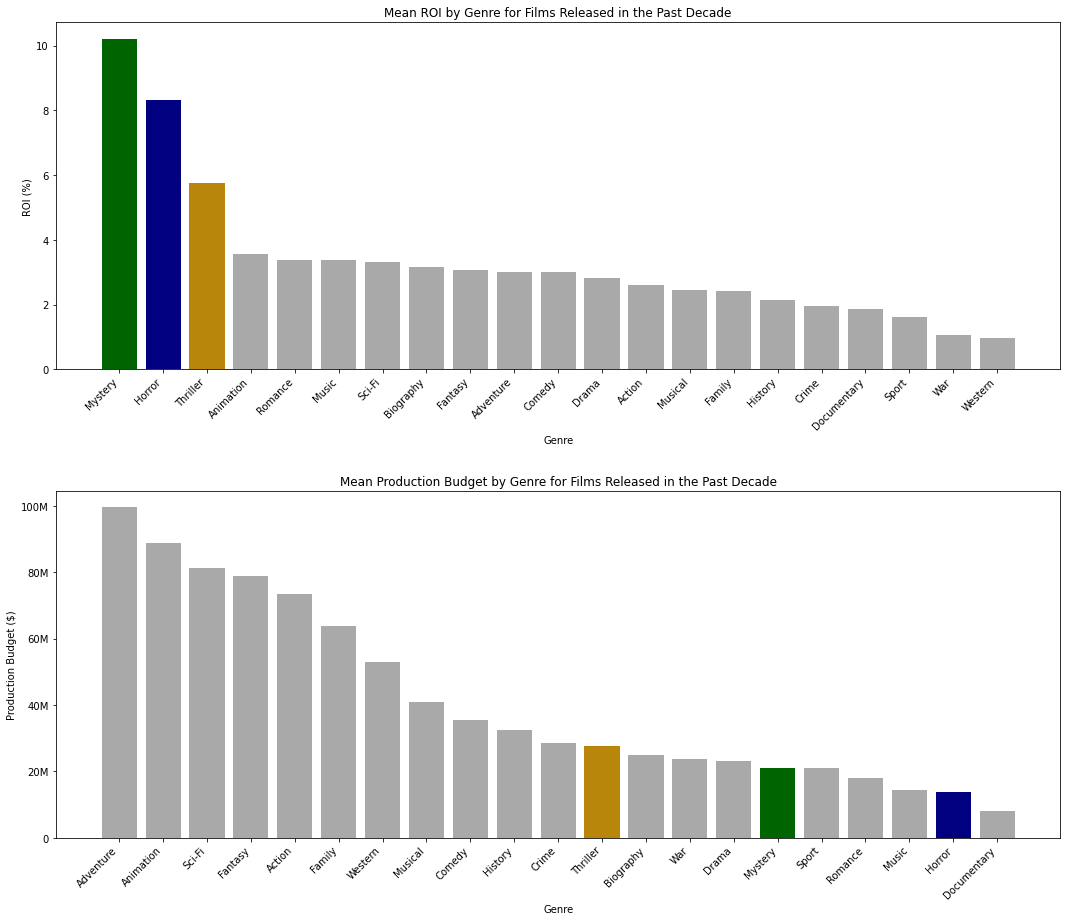

In [37]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(18,15))

colors_ax1 = ['darkgreen', 'navy', 'darkgoldenrod', 'darkgrey', 'darkgrey', 'darkgrey', 
              'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey',
              'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey',
              'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey']
ax1.bar(x=mean_ROI_by_g_df.index, height=mean_ROI_by_g_df['ROI'], color=colors_ax1)
ax1.set_xlabel('Genre')
ax1.set_ylabel('ROI (%)')
ax1.set_title('Mean ROI by Genre for Films Released in the Past Decade')

colors_ax2 = ['darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey',
              'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgrey', 'darkgoldenrod',
              'darkgrey', 'darkgrey', 'darkgrey', 'darkgreen', 'darkgrey', 'darkgrey',
              'darkgrey', 'navy', 'darkgrey']
ax2.bar(x=mean_prod_budget_by_g_df.index, height=mean_prod_budget_by_g_df['production_budget'],
        color=colors_ax2)
ax2.set_xlabel('Genre')
ax2.set_ylabel('Production Budget ($)')
ax2.set_title('Mean Production Budget by Genre for Films Released in the Past Decade')
ax2.ticklabel_format(axis='y', useOffset=False, style='plain')
y = np.array([0, 20000000, 40000000, 60000000, 80000000, 100000000])
y_ticks_labels = ["0", "20M", "40M", "60M", "80M", "100M"]
ax2.set_yticks(y)
ax2.set_yticklabels(y_ticks_labels)

plt.subplots_adjust(hspace=0.35)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right");
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right");

## Conclusion on Genres

Microsoft's new film studio should produce mystery films, horrors, or thrillers. These film genres have the highest ROI compared to the other genres types. In addition, they tend to be lower budget films, which could bode well for a brand new film studio that's entering show biz!

# Beginning of Mendy's Code

In [38]:
# Merging all the relevant data into one dataframe.
# All merges should be done with 'left merge' so that we don't lose any data.
new_df = imdb_title_principals_df.merge(imdb_title_crew_df, on='tconst', how='left')
new_df = new_df.merge(imdb_title_basics_df, on='tconst', how='left')
new_df = new_df.merge(imdb_name_basics_df, on='nconst', how='left')
master_df = new_df.merge(money_metrics_merge_ready_df, left_on='primary_title', right_on='movie', how='left')
master_df = master_df.merge(imdb_title_ratings_df, on='tconst', how='left')
master_df.drop(['original_title', 'birth_year', 'death_year', 'ordering', 'job', 'characters'], axis=1, inplace=True)

In [39]:
master_df

,tconst,nconst,category,directors,writers,primary_title,start_year,runtime_minutes,genres,primary_name,...,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN,averagerating,numvotes
0,tt0111414,nm0246005,actor,nm0398271,nm0398271,A Thin Life,2018,75.0,Comedy,Tommy Dysart,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0111414,nm0398271,director,nm0398271,nm0398271,A Thin Life,2018,75.0,Comedy,Frank Howson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0111414,nm3739909,producer,nm0398271,nm0398271,A Thin Life,2018,75.0,Comedy,Barry Porter-Robinson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0323808,nm0059247,editor,nm0362736,nm0362736,The Wicker Tree,2011,96.0,"Drama,Horror",Sean Barton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,2328.0
4,tt0323808,nm3579312,actress,nm0362736,nm0362736,The Wicker Tree,2011,96.0,"Drama,Horror",Brittania Nicol,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,2328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028181,tt9692684,nm0186469,actor,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Kenneth Cranham,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028182,tt9692684,nm4929530,self,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Pearl Mackie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028183,tt9692684,nm10441594,director,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Guy Jones,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028184,tt9692684,nm6009913,writer,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Sabrina Mahfouz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Directors and Actors impact.

To get a sense of what kind of impact the directors have on movies, we will first take subsets of the data which have only successful movies, and compare those directors with the directors of movies that performed poorly. We can then see if it is true that you can rely on a director to make the movie successful.
We'll then do the same for actors.

In [40]:
# Make a dataframe that only contains movies that had an above average return on investment.
above_average_movies = master_df[master_df['ROI'] >= money_metrics_df['ROI'].mean()]

# Make a series of all the director's names, and how many of their movies were above average.
aam_directors = above_average_movies[(above_average_movies['category'] == 'director')]['primary_name'].value_counts()

Let's look at a sample of the 50 directors with the most movies that were succesful based on ROI

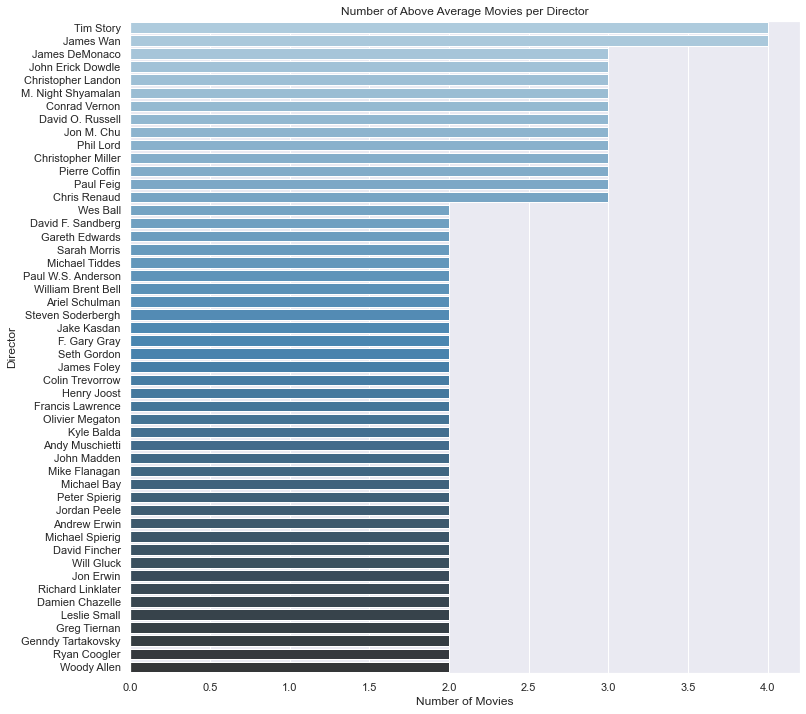

In [41]:
# Plot the 50 most successful names, and the number of movies of each director for above average movies.
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=aam_directors.values.tolist()[:50], y=aam_directors.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Above Average Movies per Director')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Director');

Some unfamilar names there.This is because it's based on ROI, rather than gross revenue. So these guys get good bang for their buck.

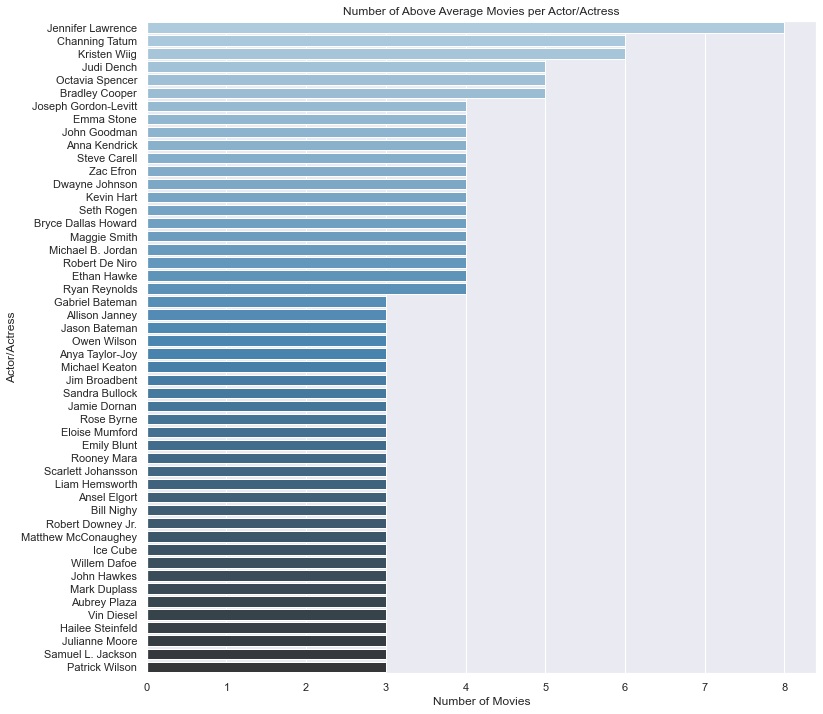

In [42]:
# Make the same series for actors and actresses.
aam_actor_actress = above_average_movies[(above_average_movies['category'] == 'actor') | \
                           (above_average_movies['category'] == 'actress')]['primary_name'].value_counts()

# let's look at the same sample for actors/actresses.
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=aam_actor_actress.values.tolist()[:50], y=aam_actor_actress.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Above Average Movies per Actor/Actress')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Actor/Actress');

Now we'll do the same with poor performers. But we'll only take movies that had a relatively large budget, so we eliminate the movies that, due to low budget, never had a chance to begin with.

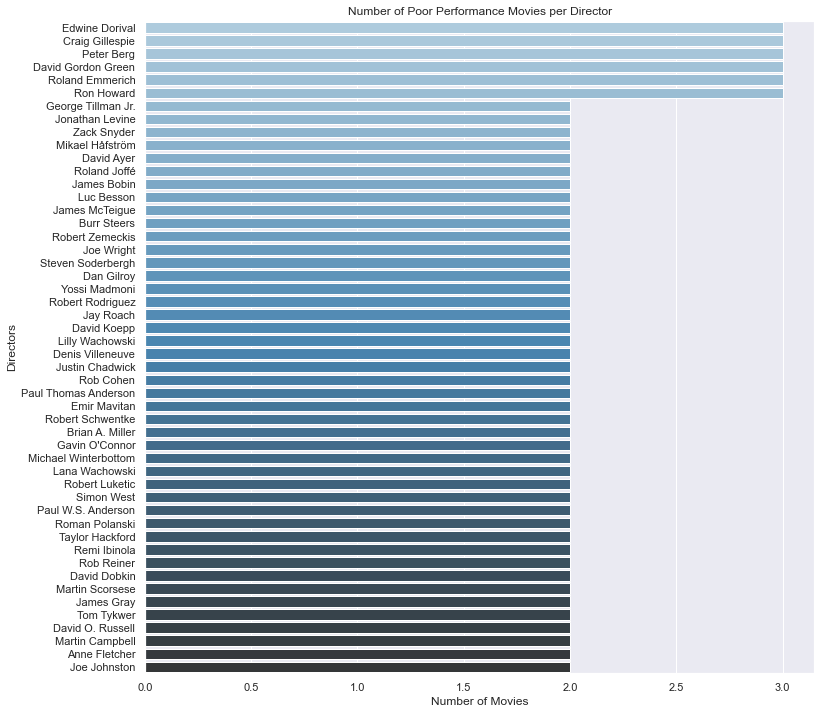

In [43]:
# Set the standard for poor performance movies at having a high budget and a low ROI.
poor_performance_movies = master_df[(master_df['ROI'] <= money_metrics_df['ROI'].median()) & \
          (master_df['production_budget'] >= money_metrics_df['production_budget'].median())]

# Take all the directors from the poor performing movies.
ppm_directors = poor_performance_movies[(poor_performance_movies['category'] == 'director')]['primary_name'].value_counts()

# Plot the 50 least successful names and the number of movies for each director for poor performing movies.
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=ppm_directors.values.tolist()[:50], y=ppm_directors.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Poor Performance Movies per Director')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Directors');

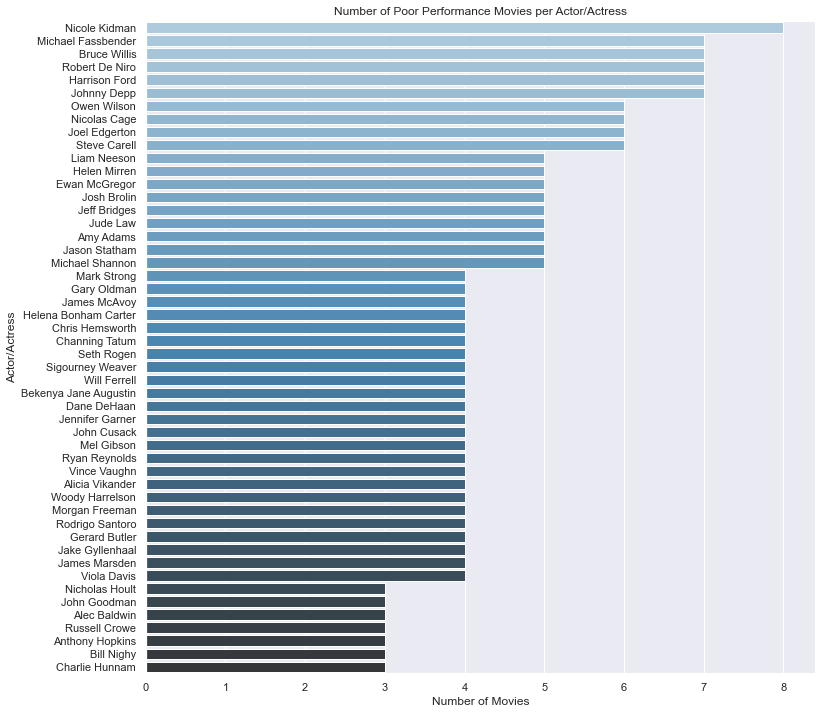

In [44]:
# Continue the same process for actors/actresses in poor prformance movies.
ppm_actor_actress = poor_performance_movies[(poor_performance_movies['category'] == 'actor') | \
                           (poor_performance_movies['category'] == 'actress')]['primary_name'].value_counts()
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=ppm_actor_actress.values.tolist()[:50], y=ppm_actor_actress.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Poor Performance Movies per Actor/Actress')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Actor/Actress');

Now we'll check to see if the directors, as well as the actors, of the really successful movies also made failed movies.

In [45]:
# Use ".intersection" to check how many of the successful movie directors, also directed failed movies.
num_dirs_with_good_bad = len(set(ppm_directors.index.tolist()).intersection( aam_directors.index.tolist()))
# Check what percent of good movie directors have also directed bad movies.
per_good_dirs_with_bad = round(num_dirs_with_good_bad/len(aam_directors)*100, 2)

# Use ".intersection" to check how many of the successful movie actors, also acted in failed movies.
num_acts_with_good_bad = len(set(aam_actor_actress.index.tolist()).intersection(ppm_actor_actress.index.tolist()))
# Check what percent of good movie actors have also acted in  bad movies.
per_good_acts_with_bad = round(num_acts_with_good_bad/len(aam_actor_actress)*100, 2)

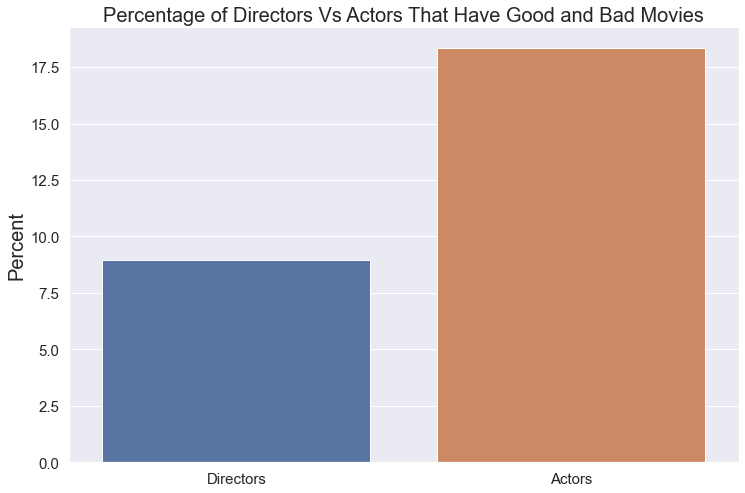

In [46]:
# Plot the difference between the percentages.
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x=['Directors', 'Actors'], y=[per_good_dirs_with_bad, per_good_acts_with_bad])
ax.set_title('Percentage of Directors Vs Actors That Have Good and Bad Movies', size=20)
ax.set_ylabel('Percent', size=20)
ax.set_xticklabels(labels=['Directors', 'Actors'], size=15)
ax.set_yticklabels(ax.get_yticks(), size=15);

We see that the director of a movie will have a bigger impact on its success than the actors.

Lets see if when we filter our above_average_movies to be only big films, if the results will be any different. Lets say that we're only going to look at movies that have higher than the median production budgets.

In [47]:
# Add the condition that the production budget needs to be bigger than the median.
bm_above_average_movies = master_df[(master_df['ROI'] >= money_metrics_df['ROI'].mean()) &\
                                   (master_df['production_budget'] >= money_metrics_df['production_budget'].median())]

aa_big_movie_directors = bm_above_average_movies[(bm_above_average_movies['category'] == 'director')]\
                         ['primary_name'].value_counts()

bm_aam_actor_actress = bm_above_average_movies[(bm_above_average_movies['category'] == 'actor') | \
                    (bm_above_average_movies['category'] == 'actress')]['primary_name'].value_counts()

In [48]:
# Use ".intersection" to check how many of the successful movie directors, also directed failed movies.
bm_num_dirs_with_good_bad = len(set(aa_big_movie_directors.index.tolist()).intersection(ppm_directors.index.tolist()))
# Check what percent of good movie directors have also directed bad movies.
bm_per_good_dirs_with_bad = round(num_dirs_with_good_bad/len(aa_big_movie_directors)*100, 2)

# Use ".intersection" to check how many of the successful movie actors, also acted in failed movies.
bm_num_acts_with_good_bad = len(set(bm_aam_actor_actress.index.tolist()).intersection(ppm_actor_actress.index.tolist()))
# Check what percent of good movie actors have also acted in  bad movies.
bm_per_good_acts_with_bad = round(num_acts_with_good_bad/len(bm_aam_actor_actress)*100, 2)

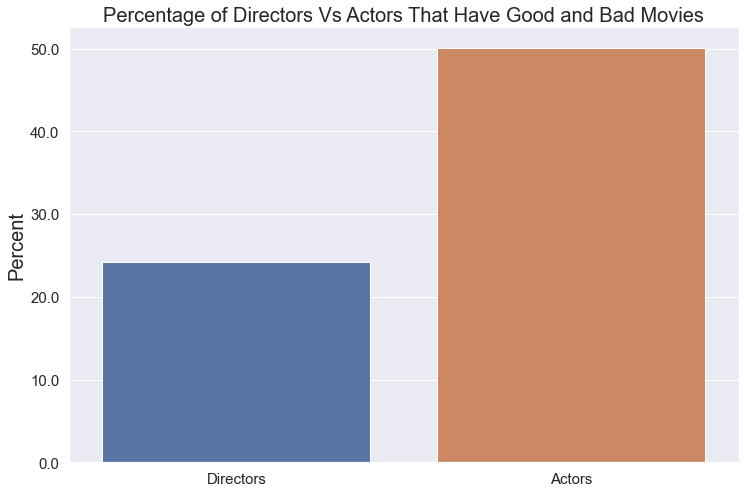

In [49]:
# Plot the difference between the percentages.
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x=['Directors', 'Actors'], y=[bm_per_good_dirs_with_bad, bm_per_good_acts_with_bad])
ax.set_title('Percentage of Directors Vs Actors That Have Good and Bad Movies', size=20)
ax.set_ylabel('Percent', size=20)
ax.set_xticklabels(labels=['Directors', 'Actors'], size=15)
ax.set_yticklabels(ax.get_yticks(), size=15);

As expected, when we make take less data the differences get bigger.
Let's flip this graph around and take the positive numbers from it.

In [50]:
# What percentage of directors/actors who were in high budget films that did well,
# have never done films that did poorly.
bm_per_dir_only_good = round((1-num_dirs_with_good_bad/len(aa_big_movie_directors))*100,2)
bm_per_acts_only_good = round((1-num_acts_with_good_bad/len(bm_aam_actor_actress))*100,2)

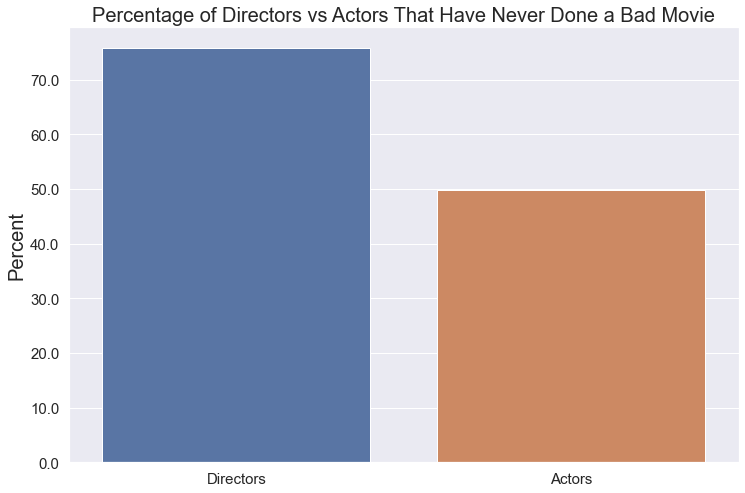

In [51]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x=['Directors', 'Actors'], y=[bm_per_dir_only_good, bm_per_acts_only_good])
ax.set_title('Percentage of Directors vs Actors That Have Never Done a Bad Movie', size=20)
ax.set_ylabel('Percent', size=20)
ax.set_xticklabels(labels=['Directors', 'Actors'], size=15)
ax.set_yticklabels(ax.get_yticks(), size=15);

We can conclude from our exploring, that it probably isn't wise to chase after the most expensive actors or actresses, since we see that many of them who have done really successful movies, have also done movies that did not perform well. This tells us, that while we know a good movie needs good acting, just because a movie has a very popular actor, the fans of this actor alone, are not going to be enough to push the needle and make it a profitable movie. For the directors, it seems that they definetely have a significant impact on the ROI. We see that from all the directors who have done successful movies, 70% of them have never done a flopped movie. So even though sometimes a good director can have a bad movie, overall money spent on a director is well spent.

## The Monthly Breakdown

A common staple of the Hollywood schedule is the seasonal trends. October for horror, summer for action, awards season bait in the winter. But how does this shake out as far as ROI goes?

In [52]:
#grabbing the mmmr_df from above

months_and_years_df = money_metrics_merge_ready_df

#dropping the zeros gross films
#This may be be very generous to our ROI data later, but we have to assume a literal 0 return is 
#more likely bad data in than a literal 0 revenue. 
#these film makers have parents, that at least would provide some box office.
months_and_years_df = months_and_years_df[months_and_years_df['worldwide_gross'] != 0].copy()


# Removing Deep Throat on principle. It's numbers were apparently pumped by mob involvement and
# apparently the lead talent was coerced into performing, which, ick.
# Also it's messing up my graphs.
months_and_years_df = months_and_years_df.sort_values('ROI', ascending = False)
months_and_years_df = months_and_years_df.drop([5745])


In [53]:
##Making a series in the data frame that will let us sort our months in order.
months_and_years_df['alphaMonths']=months_and_years_df['Month']

#A brute function to cycle through
def alphamonth(month):
    if month == 'Jan':
        amonth = '01 - January'
    elif month == 'Feb':
        amonth = '02 - February'
    elif month == 'Mar':
        amonth = '03 - March'
    elif month == 'Apr':
        amonth = '04 - April'
    elif month == 'May':
        amonth = '05 - May'
    elif month == 'Jun':
        amonth = '06 - June'
    elif month == 'Jul':
        amonth = '07 - July'
    elif month == 'Aug':
        amonth = '08 - August'
    elif month == 'Sep':
        amonth = '09 - September'
    elif month == 'Oct':
        amonth = '10 - October'
    elif month == 'Nov':
        amonth = '11 - November'
    elif month == 'Dec':
        amonth = '12 - December'
    return amonth

#And .map ing that through the df
months_and_years_df['alphaMonths']=months_and_years_df['alphaMonths'].map(alphamonth) 

#functions to pull years, months out of the data set. Can also be used for other column types?

#for now, use int types for the year
def year_iso (df, year):
    output_df = df[df['Year'] == year]
    return output_df


#for now, with money_metrics_df, use three letter abreviations for months
def month_iso (df, month):
    output_df = df[df['Month'] == month]
    return output_df


#A function to take any dataframe e.g. an isolated year, and get a monthly breakdown
def run_the_months(df):
    month_list= ['January','February','March', 'April', 'May','June','July','August',
                           'September','October','November','December']
    df_list=[]
    for i in month_list:
        month_abrev= i[0:3]
        data_frame_to_list = month_iso(df , month_abrev)
        df_list.append(data_frame_to_list)
        output_dict = dict(zip(month_list, df_list))    
    return output_dict




A Block of useful funtions

Experimentation revealed that early data was too sparse and noise to analyse well, and likely had less bearing on modern trends. A new dataframe for 1980 and beyond was created.


In [54]:
#Let's push this to be a post 1970's display. A lot of the pre-70s data is too thin on the ground.
#Most execs' oldest movie memories probably goes back to about the 80's


post_70s_df =  months_and_years_df[months_and_years_df['Year'] >= 1980]

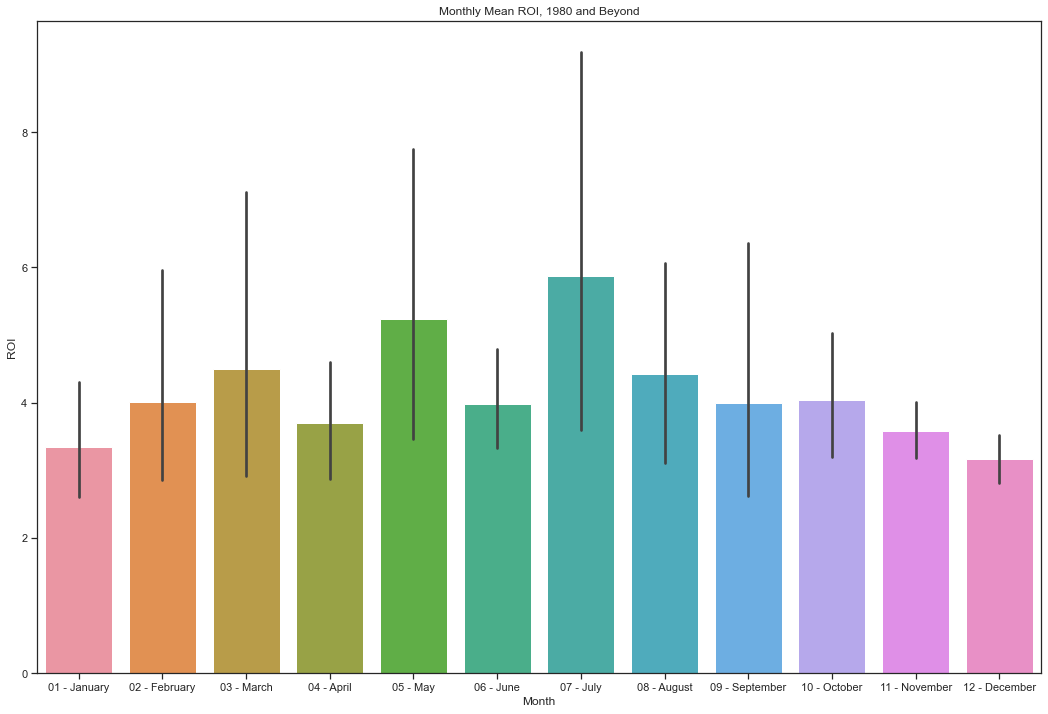

In [55]:
### Using seaborn to get a pretty graph of ROI by month. Also, automates a lot of previous work. C'est la vie.
### Default estimator is mean, which works for us.

figure(figsize=(18, 12))
sns.set_style("ticks")
plt.title('Monthly Mean ROI, 1980 and Beyond')
sns.barplot(data = post_70s_df.sort_values('alphaMonths'), x = 'alphaMonths', y = 'ROI')
plt.xlabel('Month');

#May and July stand out.

There clearly are trends here. May and July stand out as creat times to release. December and January seem less promising. But let's dig a bit deeper. The Hollywood seasons are often associated with different genres. Let's break down our top genres by month.

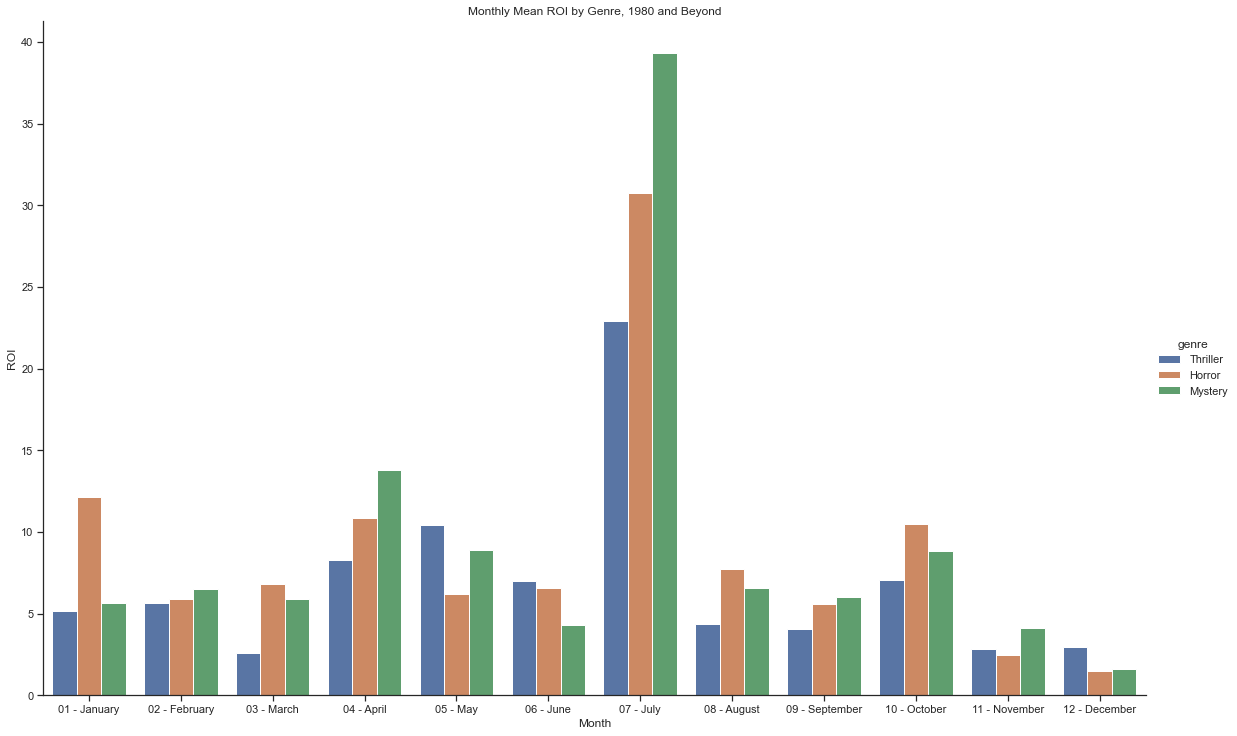

In [56]:
### Let's do by month AND genre

#dropping all other columns to make merging simpler
genre_barebones = all_g_df[['movie','genre']]

genre_month_merge = post_70s_df.merge(genre_barebones, how= 'inner', left_on = 'movie', right_on= 'movie')

#Plotting the top three genres by month
top_three_genre = genre_month_merge[(genre_month_merge['genre'] == 'Horror') | 
                                    (genre_month_merge['genre'] == 'Mystery') 
                                    | (genre_month_merge['genre'] == 'Thriller')]

#sorting by alphamonths to make the incoming graph sort Jan-Dec
top_three_genre.sort_values('alphaMonths', inplace = True)


###And plot it all!
sns.catplot(data = top_three_genre, x = 'alphaMonths', y = 'ROI', hue="genre", 
            kind="bar",height=10, ci= None, aspect =1.6 )
sns.set_style("ticks")
plt.title('Monthly Mean ROI by Genre, 1980 and Beyond')
plt.xlabel('Month');
#I'm trimming out the error bars, but this sucker is *noisy*

Here we find some surprises! January, it turns out, is a pretty good time to release a horror film! Thrillers do well in April.

Film release dates should take genre into consideration. 